In [1]:
import pandas as pd
import numpy as np

import sys
import os
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)

In [2]:
# inflow = pd.read_parquet('/uss/hdsi-prismdata/q1-ucsd-inflows.pqt')
# outflow = pd.read_parquet('/uss/hdsi-prismdata/q1-ucsd-outflows.pqt')

# # remove rows where memo = category
# outflow = outflow[outflow['memo'] != outflow['category']]

# outflow_ids = set(outflow["prism_consumer_id"].unique())
# inflow_ids = set(inflow["prism_consumer_id"].unique())

# in_not_out = inflow_ids - outflow_ids
# out_not_in = outflow_ids - inflow_ids

# #consumers in both inflow and outflow
# consumers_both = sorted(set(inflow["prism_consumer_id"]).intersection(outflow["prism_consumer_id"]))

# #80-20 train test split
# train_ids, test_ids = train_test_split(consumers_both, test_size=0.2, random_state=42)

# inflow_train = inflow[inflow["prism_consumer_id"].isin(train_ids)]
# inflow_test  = inflow[inflow["prism_consumer_id"].isin(test_ids)]

# outflow_train = outflow[outflow["prism_consumer_id"].isin(train_ids)]
# outflow_test  = outflow[outflow["prism_consumer_id"].isin(test_ids)]

# # print(f'Inflow_train: {inflow_train["amount"].median()}\nInflow_test: {inflow_test["amount"].median()}\nOutflow_train: {outflow_train["amount"].median()}\nOutflow_test: {outflow_test["amount"].median()}')

from src.traintest_split import train_test
inflow_train, inflow_test, outflow_train, outflow_test = train_test()

In [3]:
inflow_train['posted_date'] = pd.to_datetime(inflow_train['posted_date'], errors='coerce')
# it_sorted = inflow_train.sort_values(['prism_consumer_id', 'prism_account_id', 'posted_date'])
it_sorted = inflow_train.sort_values(['prism_consumer_id', 'posted_date'])
# it_sorted['interval'] = it_sorted.groupby('prism_consumer_id')['posted_date'].diff().dt.days
it_sorted['is_recurring_income'] = False

In [4]:
# def cluster_amounts(df, amount_col='amount', tolerance=0.10):
#     """
#     Clusters values in df[amount_col] such that each cluster 
#     contains values within ±tolerance of the cluster median.
#     Returns df with a new column 'cluster_id'.
#     """
    
#     # Sort by amount
#     temp = df.copy().sort_values(amount_col)
#     amounts = temp[amount_col].values

#     clusters = []
#     current_cluster = [amounts[0]]

#     for value in amounts[1:]:
#         median_val = np.median(current_cluster)

#         # Check if within tolerance range
#         if abs(value - median_val) <= tolerance * median_val:
#             current_cluster.append(value)
#         else:
#             # Close this cluster, start a new one
#             clusters.append(current_cluster)
#             current_cluster = [value]

#     # Append last cluster
#     clusters.append(current_cluster)

#     # Assign cluster IDs back to original dataframe
#     cluster_id_map = {}
#     cluster_id = 0

#     for cluster in clusters:
#         for val in cluster:
#             cluster_id_map.setdefault(val, [])
#             cluster_id_map[val].append(cluster_id)
#         cluster_id += 1

#     # If multiple equal amounts appear, assign the cluster in sequential order
#     cluster_ids = []
#     counter = {val: 0 for val in cluster_id_map.keys()}
    
#     for val in df[amount_col]:
#         cid_list = cluster_id_map[val]
#         cid = cid_list[counter[val]]
#         cluster_ids.append(cid)
#         counter[val] += 1

#     df = df.copy()
#     df['cluster_id'] = cluster_ids
#     return df

In [5]:
from src.income_recurrence import cluster_amounts, detect_recurring_transactions

# choose 1 acc form 1 consumer as test (change this when not restricting acc)
test = it_sorted[(it_sorted['prism_consumer_id'] == 0)]

# form clusters
cluster_df = cluster_amounts(test)
# for each cluster: check recurrence 3x
# clusters = cluster_df['cluster_id']
# for i in clusters:
    

In [6]:
# from itertools import combinations
# # from dateutil.relativedelta import relativedelta

# def detect_recurring_transactions(df, date_col='posted_date', cluster_col='cluster_id'):
#     """
#     For each amount cluster, detect recurring sub-sequences.
#     ONLY mark transactions that actually appear in a pattern (>= 3).
    
#     Output column: is_recurring_income (per-row)
#     """
    
#     df = df.copy()
#     df[date_col] = pd.to_datetime(df[date_col])
#     df['is_recurring_income'] = False  # initialize
    
#     # Helper: check recurrence between 2 timestamps
#     def matches_pattern(d1, d2):
#         diff = abs((d2 - d1) / np.timedelta64(1, 'D'))
#         return (
#             (5 <= diff <= 9) or     # weekly
#             (12 <= diff <= 16) or   # biweekly
#             (28 <= diff <= 33)      # monthly
#         )
    
#     # Process by cluster
#     for cid, temp in df.groupby(cluster_col):
        
#         temp = temp.sort_values(date_col)
#         dates = temp[date_col].values
#         idxs  = temp.index.values  # important for marking back into df
        
#         n = len(dates)
#         if n < 3:
#             continue
        
#         # Store ALL recurring groups of length >= 3
#         recurring_groups = []
        
#         for i in range(n):
#             base_date = dates[i]
#             base_idx  = idxs[i]
            
#             group_dates = [base_date]
#             group_idxs  = [base_idx]
            
#             # try extend pattern starting at date i
#             for j in range(i+1, n):
#                 cur_date = dates[j]
#                 cur_idx  = idxs[j]
                
#                 last_date = group_dates[-1]
                
#                 if matches_pattern(last_date, cur_date):
#                     group_dates.append(cur_date)
#                     group_idxs.append(cur_idx)
            
#             # Only keep groups with >= 3 transactions
#             # if len(group_dates) >= 3:
#             if (group_dates[-1] - group_dates[0]) >= np.timedelta64(90, 'D'):
#                 recurring_groups.append(group_idxs)
        
#         # Flatten all indices of recurring groups
#         recurring_idxs = set(idx for grp in recurring_groups for idx in grp)
        
#         # Mark ONLY those transactions as recurring
#         df.loc[list(recurring_idxs), 'is_recurring_income'] = True
    
#     return df

In [7]:
# def detect_recurring_transactions(df, date_col='posted_date', cluster_col='cluster_id'):
    
#     df = df.copy()
#     df[date_col] = pd.to_datetime(df[date_col])
#     df['is_recurring_income'] = False
    
#     def matches_pattern(d1, d2):
#         diff = abs((d2 - d1) / np.timedelta64(1, 'D'))
#         return (
#             (5 <= diff <= 9) or        # weekly
#             (12 <= diff <= 16) or      # biweekly
#             (28 <= diff <= 33)         # monthly
#         )
    
#     for cid, temp in df.groupby(cluster_col):
        
#         temp = temp.sort_values(date_col)
#         dates = temp[date_col].values
#         idxs  = temp.index.values
        
#         n = len(dates)
#         if n < 3:
#             continue
        
#         recurring_groups = []

#         for i in range(n):
#             group_dates = [dates[i]]
#             group_idxs  = [idxs[i]]

#             j = i + 1

#             # OPTIMIZED: only compare within ~1 month of the LAST matched date
#             while j < n and (dates[j] - group_dates[-1]) <= np.timedelta64(33, 'D'):

#                 if matches_pattern(group_dates[-1], dates[j]):
#                     group_dates.append(dates[j])
#                     group_idxs.append(idxs[j])

#                 j += 1

#             # keep groups with >= 3 transactions
#             if len(group_dates) >= 3:
#                 recurring_groups.append(group_idxs)

#         # flatten unique transaction indices
#         recurring_idxs = {idx for grp in recurring_groups for idx in grp}

#         df.loc[list(recurring_idxs), 'is_recurring_income'] = True
    
#     return df

In [8]:
out = detect_recurring_transactions(cluster_df)
out

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
73,0,acc_0,EXTERNAL_TRANSFER,37000.00,2022-02-14,EXTERNAL_TRANSFER,False,21
14,0,acc_1,INVESTMENT_INCOME,0.04,2022-02-17,INVESTMENT_INCOME,False,0
18,0,acc_0,EXTERNAL_TRANSFER,25.00,2022-02-18,EXTERNAL_TRANSFER,False,4
27,0,acc_0,PAYCHECK,2331.71,2022-02-18,PAYCHECK,True,20
20,0,acc_0,EXTERNAL_TRANSFER,75.00,2022-02-24,EXTERNAL_TRANSFER,False,8
...,...,...,...,...,...,...,...,...
7,0,acc_1,INVESTMENT_INCOME,0.04,2023-01-20,INVESTMENT_INCOME,True,0
17,0,acc_0,PAYCHECK,2547.35,2023-01-20,PAYCHECK,True,20
26,0,acc_0,EXTERNAL_TRANSFER,100.00,2023-01-20,EXTERNAL_TRANSFER,True,10
62,0,acc_0,EXTERNAL_TRANSFER,97.00,2023-01-27,EXTERNAL_TRANSFER,True,10


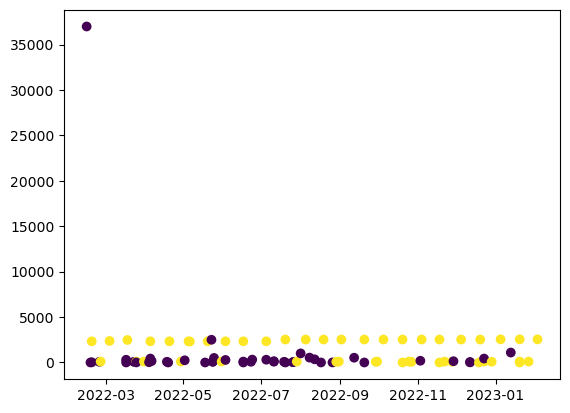

In [9]:
import matplotlib.pyplot as plt
plt.scatter(out['posted_date'], out['amount'], c=out['is_recurring_income'])

In [10]:
out[out['is_recurring_income'] == True]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
27,0,acc_0,PAYCHECK,2331.71,2022-02-18,PAYCHECK,True,20
83,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-02-25,EXTERNAL_TRANSFER,True,10
86,0,acc_0,PAYCHECK,2371.46,2022-03-04,PAYCHECK,True,20
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK,True,20
15,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-03-25,EXTERNAL_TRANSFER,True,10
71,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-03-31,EXTERNAL_TRANSFER,True,10
38,0,acc_0,PAYCHECK,2331.71,2022-04-05,PAYCHECK,True,20
65,0,acc_0,PAYCHECK,2331.71,2022-04-20,PAYCHECK,True,20
69,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-04-29,EXTERNAL_TRANSFER,True,10
25,0,acc_0,PAYCHECK,2331.71,2022-05-05,PAYCHECK,True,20


In [11]:
out[(out['category'] == 'PAYCHECK') | (out['category'] == 'PAYCHECK_PLACEHOLDER')]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
27,0,acc_0,PAYCHECK,2331.71,2022-02-18,PAYCHECK,True,20
86,0,acc_0,PAYCHECK,2371.46,2022-03-04,PAYCHECK,True,20
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK,True,20
38,0,acc_0,PAYCHECK,2331.71,2022-04-05,PAYCHECK,True,20
65,0,acc_0,PAYCHECK,2331.71,2022-04-20,PAYCHECK,True,20
25,0,acc_0,PAYCHECK,2331.71,2022-05-05,PAYCHECK,True,20
31,0,acc_0,PAYCHECK,2331.71,2022-05-20,PAYCHECK,True,20
28,0,acc_0,PAYCHECK,2331.71,2022-06-03,PAYCHECK,True,20
41,0,acc_0,PAYCHECK,2331.71,2022-06-17,PAYCHECK,True,20
51,0,acc_0,PAYCHECK,2331.63,2022-07-05,PAYCHECK,True,20


In [12]:
out[-20:]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
58,0,acc_1,INVESTMENT_INCOME,0.04,2022-11-18,INVESTMENT_INCOME,True,0
84,0,acc_0,PAYCHECK,2528.40,2022-11-18,PAYCHECK,True,20
12,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-11-22,EXTERNAL_TRANSFER,True,10
33,0,acc_0,EXTERNAL_TRANSFER,80.00,2022-11-28,EXTERNAL_TRANSFER,True,8
37,0,acc_0,EXTERNAL_TRANSFER,139.00,2022-11-29,EXTERNAL_TRANSFER,False,11
75,0,acc_0,PAYCHECK,2526.19,2022-12-05,PAYCHECK,True,20
36,0,acc_0,EXTERNAL_TRANSFER,15.00,2022-12-12,EXTERNAL_TRANSFER,False,3
79,0,acc_0,EXTERNAL_TRANSFER,50.00,2022-12-12,EXTERNAL_TRANSFER,False,7
63,0,acc_1,INVESTMENT_INCOME,0.04,2022-12-19,INVESTMENT_INCOME,True,0
77,0,acc_0,PAYCHECK,2526.19,2022-12-20,PAYCHECK,True,20
